In [0]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,classification_report,make_scorer,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split,GridSearchCV # Import train_test_split function

#for visualization
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

from sklearn.utils import resample

import warnings
warnings.simplefilter('ignore')


In [0]:
! mkdir /content/data
!cp *.csv /content/data

In [0]:
companyDf = pd.read_csv('./data/companies.csv')
acquisitionDf = pd.read_csv('./data/acquisitions.csv')
investmentDf = pd.read_csv('./data/investments.csv')
roundsDf = pd.read_csv('./data/rounds.csv')


In [90]:
companyDf.head()

permalink  ... last_funding_at
0                  /organization/-fame  ...      2015-01-05
1               /organization/-qounter  ...      2014-10-14
2  /organization/-the-one-of-them-inc-  ...      2014-01-30
3                /organization/0-6-com  ...      2008-03-19
4       /organization/004-technologies  ...      2014-07-24

[5 rows x 14 columns]

In [91]:
companyDf.rename({'permalink':'company_permalink', 'name':'company_name', 'category_list':'company_category_list','country_code':'company_country_code','state_code':'company_state_code','region':'company_region','city':'company_city'}, axis=1, inplace=True)
companyDf.head()

company_permalink  ... last_funding_at
0                  /organization/-fame  ...      2015-01-05
1               /organization/-qounter  ...      2014-10-14
2  /organization/-the-one-of-them-inc-  ...      2014-01-30
3                /organization/0-6-com  ...      2008-03-19
4       /organization/004-technologies  ...      2014-07-24

[5 rows x 14 columns]

In [92]:
companyDf['company_country_code'].value_counts()

USA    37601
GBR     3688
CAN     1925
IND     1596
CHN     1544
       ...  
IRN        1
TGO        1
BRN        1
GGY        1
JEY        1
Name: company_country_code, Length: 137, dtype: int64

**From the above counts, maximum number of companies are of USA. So, instead of analysing success for all the data, we filter out the data of USA and try to analyse whether to invsest in the companies in future.**

In [0]:
##filtering the data of USA only.

companyUSADf = companyDf.loc[companyDf['company_country_code']=='USA']
roundsUSADf = roundsDf.loc[roundsDf['company_country_code']=='USA']
acquisitionUSADf = acquisitionDf.loc[acquisitionDf['company_country_code']=='USA']
investUSADf = investmentDf.loc[investmentDf['company_country_code']=='USA']
 
 

In [94]:
print(companyUSADf.shape)
print(roundsUSADf.shape)
print(investUSADf.shape)
print(acquisitionUSADf.shape)
companyUSADf.head()


(37601, 14)
(72308, 12)
(112283, 18)
(10468, 18)


company_permalink  ... last_funding_at
1           /organization/-qounter  ...      2014-10-14
4   /organization/004-technologies  ...      2014-07-24
7             /organization/0xdata  ...      2015-11-09
8                  /organization/1  ...      2014-02-05
10           /organization/1-4-all  ...      2013-04-21

[5 rows x 14 columns]

In [95]:
companyUSADf.isna().sum()

company_permalink           0
company_name                1
homepage_url             2941
company_category_list     946
funding_total_usd           0
status                      0
company_country_code        0
company_state_code         42
company_region            108
company_city              108
funding_rounds              0
founded_at               7000
first_funding_at           12
last_funding_at             0
dtype: int64

In [96]:
companyCategory = companyUSADf.groupby('company_category_list')['company_permalink'].count().reset_index().sort_values(by='company_permalink', ascending=False)
companyCategory.head(100)

company_category_list  company_permalink
15253                          Software               2674
4541                      Biotechnology               2658
12599                       Health Care                691
5831                   Clean Technology                677
8202                        Curated Web                642
...                                 ...                ...
15097                 Security|Software                 15
12726  Health Care|Medical|Therapeutics                 15
12670     Health Care|Hospitals|Medical                 15
1558                 Analytics|Big Data                 15
7054      Computers|Software|Technology                 15

[100 rows x 2 columns]

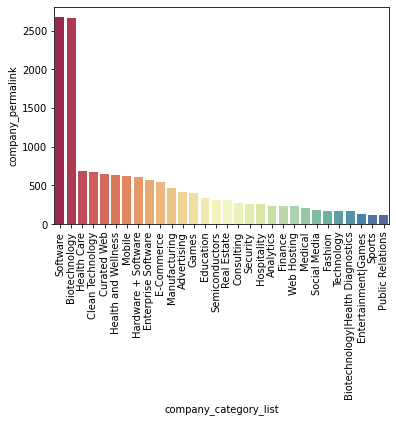

In [97]:
sns.barplot(x='company_category_list', y='company_permalink',data=companyCategory.head(30),palette='Spectral')
plt.xticks(rotation=90)
plt.show()

In [98]:
roundsUSADf.head()

company_permalink  ... raised_amount_usd
1           /organization/-qounter  ...               NaN
2           /organization/-qounter  ...          700000.0
5   /organization/004-technologies  ...               NaN
9             /organization/0xdata  ...         3000000.0
10            /organization/0xdata  ...        20000000.0

[5 rows x 12 columns]

In [99]:
investUSADf.head()

company_permalink  ... raised_amount_usd
1  /organization/004-technologies  ...               NaN
3            /organization/0xdata  ...        20000000.0
4            /organization/0xdata  ...         3000000.0
5            /organization/0xdata  ...        20000000.0
6            /organization/0xdata  ...         1700000.0

[5 rows x 18 columns]

In [100]:
fundingInfoDf = roundsUSADf.groupby('company_permalink').agg({'funded_at':['min','max','count']})
fundingInfoDf.columns = fundingInfoDf.columns.droplevel(0)
fundingInfoDf.rename({'min':'first_funding', 'max':'last_funding', 'count':'funding_rounds'},axis=1,inplace=True)
fundingInfoDf.head()

first_funding last_funding  funding_rounds
company_permalink                                                        
/organization/-qounter            2014-03-01   2014-10-14               2
/organization/004-technologies    2014-07-24   2014-07-24               1
/organization/0xdata              2013-01-03   2015-11-09               4
/organization/1                   2011-07-20   2014-02-05               3
/organization/1-4-all             2013-04-21   2013-04-21               1

**Some of the data of first_funding_at in company dataset seem to be garbage. So, we tried to find it using another dataset (rounds.csv). We are given the information in funded_at about the time of minimum investment and maximum investment. The above dataset shows about the information we extracted from rounds.csv. We can use this later on to merge to main dataframe.**

In [101]:
fundingTypeDf = roundsUSADf.groupby(['company_permalink','funding_round_type'])['funding_round_permalink'].count().reset_index()
fundTypeDf = fundingTypeDf.pivot(index='company_permalink', columns='funding_round_type', values = 'funding_round_permalink')
fundTypeDf = fundTypeDf.fillna(0)
fundTypeDf.head()

funding_round_type              angel  convertible_note  ...  undisclosed  venture
company_permalink                                        ...                      
/organization/-qounter            0.0               0.0  ...          0.0      1.0
/organization/004-technologies    0.0               0.0  ...          0.0      1.0
/organization/0xdata              0.0               0.0  ...          0.0      3.0
/organization/1                   0.0               0.0  ...          1.0      0.0
/organization/1-4-all             0.0               0.0  ...          0.0      0.0

[5 rows x 14 columns]

In [102]:
roundsUSADf['funding_round_code'].unique()

array(['A', nan, 'B', 'C', 'D', 'E', 'G', 'F', 'H'], dtype=object)

In [103]:
fundingCodeDf = roundsUSADf.groupby(['company_permalink','funding_round_code'])['funding_round_permalink'].count().reset_index()
fundCodeDf = fundingCodeDf.pivot(index='company_permalink', columns='funding_round_code', values = 'funding_round_permalink')
fundCodeDf = fundCodeDf.fillna(0)
fundCodeDf.head()

funding_round_code            A    B    C    D    E    F    G    H
company_permalink                                                 
/organization/-qounter      1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
/organization/0xdata        1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
/organization/1000memories  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
/organization/100health     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
/organization/10x-genomics  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0

In [104]:
totalInvesters = investUSADf.groupby('company_permalink')['investor_permalink'].count().reset_index()
totalInvesters.rename({'investor_permalink':'total_investors'},axis=1,inplace=True)
totalInvesters.head()

company_permalink  total_investors
0  /organization/004-technologies                1
1            /organization/0xdata               14
2                 /organization/1               13
3     /organization/1-800-dentist                2
4      /organization/1-mainstream                1

**Also the number of investors can be the important features which helps in deciding the success/failure of the companies. So, using investment data, we calculated the number of investors investing for a particular company.**

In [105]:
companyUSADf.columns

Index(['company_permalink', 'company_name', 'homepage_url',
       'company_category_list', 'funding_total_usd', 'status',
       'company_country_code', 'company_state_code', 'company_region',
       'company_city', 'funding_rounds', 'founded_at', 'first_funding_at',
       'last_funding_at'],
      dtype='object')

In [106]:
companyFeatures = ['company_permalink','company_state_code','company_category_list','founded_at','funding_total_usd','status']
companyNewDf = companyUSADf[companyFeatures]
companyNewDf.shape


(37601, 6)

**From companies dataset, we took out the columns that we thought might be helpful for later use either as features or at the time of merging.**

In [107]:
companyNewDf.head()

company_permalink  ...     status
1           /organization/-qounter  ...  operating
4   /organization/004-technologies  ...  operating
7             /organization/0xdata  ...  operating
8                  /organization/1  ...  operating
10           /organization/1-4-all  ...  operating

[5 rows x 6 columns]

In [108]:
combinedDf = pd.merge(companyNewDf, fundingInfoDf, how='left', on='company_permalink')
combinedDf.head()

company_permalink  ... funding_rounds
0          /organization/-qounter  ...              2
1  /organization/004-technologies  ...              1
2            /organization/0xdata  ...              4
3                 /organization/1  ...              3
4           /organization/1-4-all  ...              1

[5 rows x 9 columns]

In [109]:
combinedDf = pd.merge(combinedDf, totalInvesters, how='left', on='company_permalink')
combinedDf.head()

company_permalink  ... total_investors
0          /organization/-qounter  ...             NaN
1  /organization/004-technologies  ...             1.0
2            /organization/0xdata  ...            14.0
3                 /organization/1  ...            13.0
4           /organization/1-4-all  ...             NaN

[5 rows x 10 columns]

In [110]:
combinedDf = pd.merge(combinedDf, fundTypeDf, how='left', on='company_permalink')
combinedDf.head()

company_permalink company_state_code  ... undisclosed venture
0          /organization/-qounter                 DE  ...         0.0     1.0
1  /organization/004-technologies                 IL  ...         0.0     1.0
2            /organization/0xdata                 CA  ...         0.0     3.0
3                 /organization/1                 CA  ...         1.0     0.0
4           /organization/1-4-all                 NC  ...         0.0     0.0

[5 rows x 24 columns]

In [111]:
combinedDf=pd.merge(combinedDf, fundCodeDf, how='left', on='company_permalink')
combinedDf.head()

company_permalink company_state_code  ...    G    H
0          /organization/-qounter                 DE  ...  0.0  0.0
1  /organization/004-technologies                 IL  ...  NaN  NaN
2            /organization/0xdata                 CA  ...  0.0  0.0
3                 /organization/1                 CA  ...  NaN  NaN
4           /organization/1-4-all                 NC  ...  NaN  NaN

[5 rows x 32 columns]

In [112]:
codes = ['A', 'B', 'C', 'D', 'E', 'F','G', 'H']
combinedDf[codes] = combinedDf[codes].fillna(0)
combinedDf.head()

company_permalink company_state_code  ...    G    H
0          /organization/-qounter                 DE  ...  0.0  0.0
1  /organization/004-technologies                 IL  ...  0.0  0.0
2            /organization/0xdata                 CA  ...  0.0  0.0
3                 /organization/1                 CA  ...  0.0  0.0
4           /organization/1-4-all                 NC  ...  0.0  0.0

[5 rows x 32 columns]

In [113]:
combinedDf.isna().sum()
#print(combinedDf.shape)

company_permalink            0
company_state_code          42
company_category_list      946
founded_at                7000
funding_total_usd            0
status                       0
first_funding                0
last_funding                 0
funding_rounds               0
total_investors          14489
angel                        0
convertible_note             0
debt_financing               0
equity_crowdfunding          0
grant                        0
non_equity_assistance        0
post_ipo_debt                0
post_ipo_equity              0
private_equity               0
product_crowdfunding         0
secondary_market             0
seed                         0
undisclosed                  0
venture                      0
A                            0
B                            0
C                            0
D                            0
E                            0
F                            0
G                            0
H                            0
dtype: i

In [114]:
#assigning 0 to null investors count
combinedDf.loc[combinedDf['total_investors'].isna(),'total_investors']=0
combinedDf.isna().sum()


company_permalink           0
company_state_code         42
company_category_list     946
founded_at               7000
funding_total_usd           0
status                      0
first_funding               0
last_funding                0
funding_rounds              0
total_investors             0
angel                       0
convertible_note            0
debt_financing              0
equity_crowdfunding         0
grant                       0
non_equity_assistance       0
post_ipo_debt               0
post_ipo_equity             0
private_equity              0
product_crowdfunding        0
secondary_market            0
seed                        0
undisclosed                 0
venture                     0
A                           0
B                           0
C                           0
D                           0
E                           0
F                           0
G                           0
H                           0
dtype: int64

In [115]:
#label encoding company_state_code
combinedDf['company_state_code'] = combinedDf['company_state_code'].astype('category')
combinedDf['company_state_code'] = combinedDf['company_state_code'].cat.codes
combinedDf.head()

company_permalink  company_state_code  ...    G    H
0          /organization/-qounter                   8  ...  0.0  0.0
1  /organization/004-technologies                  15  ...  0.0  0.0
2            /organization/0xdata                   4  ...  0.0  0.0
3                 /organization/1                   4  ...  0.0  0.0
4           /organization/1-4-all                  28  ...  0.0  0.0

[5 rows x 32 columns]

In [116]:
combinedDf.loc[combinedDf['funding_total_usd'].isin(['-','?']),'funding_total_usd']=np.nan
combinedDf.head()

company_permalink  company_state_code  ...    G    H
0          /organization/-qounter                   8  ...  0.0  0.0
1  /organization/004-technologies                  15  ...  0.0  0.0
2            /organization/0xdata                   4  ...  0.0  0.0
3                 /organization/1                   4  ...  0.0  0.0
4           /organization/1-4-all                  28  ...  0.0  0.0

[5 rows x 32 columns]

In [117]:
combinedDf['funding_total_usd'].describe()

count       31429
unique      10186
top       1000000
freq          649
Name: funding_total_usd, dtype: object

In [0]:
combinedDf['funding_total_usd']=combinedDf['funding_total_usd'].astype('float')

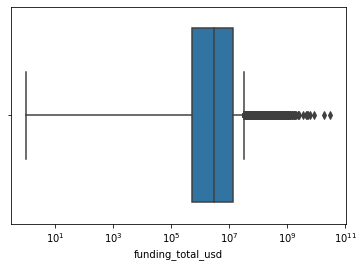

In [119]:
sns.boxplot(combinedDf[~combinedDf['funding_total_usd'].isna()]['funding_total_usd'])
plt.xscale('log')
plt.show()

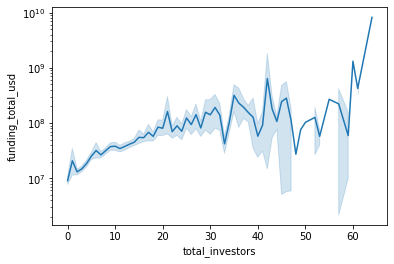

In [120]:
temp = combinedDf[~combinedDf['funding_total_usd'].isna()]
sns.lineplot(x='total_investors', y='funding_total_usd', data=temp)
plt.yscale('log')

In [121]:
temp.describe()

company_state_code  funding_total_usd  ...             G             H
count        31429.000000       3.142900e+04  ...  31429.000000  31429.000000
mean            19.827198       2.130179e+07  ...      0.001718      0.000191
std             16.098922       2.212258e+08  ...      0.047163      0.013816
min             -1.000000       1.000000e+00  ...      0.000000      0.000000
25%              4.000000       5.094120e+05  ...      0.000000      0.000000
50%             16.000000       3.000000e+06  ...      0.000000      0.000000
75%             35.000000       1.360000e+07  ...      0.000000      0.000000
max             52.000000       3.007950e+10  ...      3.000000      1.000000

[8 rows x 26 columns]

In [122]:
combinedDf['funding_total_usd'] = combinedDf.groupby('total_investors')['funding_total_usd'].transform(lambda x:x.fillna(x.mean()))
combinedDf['funding_total_usd']=np.log10(combinedDf['funding_total_usd'])
combinedDf.head()

company_permalink  company_state_code  ...    G    H
0          /organization/-qounter                   8  ...  0.0  0.0
1  /organization/004-technologies                  15  ...  0.0  0.0
2            /organization/0xdata                   4  ...  0.0  0.0
3                 /organization/1                   4  ...  0.0  0.0
4           /organization/1-4-all                  28  ...  0.0  0.0

[5 rows x 32 columns]

In [0]:
combinedDf['first_funding'] = pd.to_datetime(combinedDf.first_funding)

combinedDf['last_funding'] = pd.to_datetime(combinedDf.last_funding)

combinedDf['funding_duration'] = (combinedDf['last_funding']-combinedDf['first_funding']).astype('timedelta64[M]')
combinedDf['pseudoEstd'] = (combinedDf['first_funding']-combinedDf['first_funding'].min()).astype('timedelta64[M]')

In [124]:
combinedDf.isna().sum()

company_permalink           0
company_state_code          0
company_category_list     946
founded_at               7000
funding_total_usd           0
status                      0
first_funding               0
last_funding                0
funding_rounds              0
total_investors             0
angel                       0
convertible_note            0
debt_financing              0
equity_crowdfunding         0
grant                       0
non_equity_assistance       0
post_ipo_debt               0
post_ipo_equity             0
private_equity              0
product_crowdfunding        0
secondary_market            0
seed                        0
undisclosed                 0
venture                     0
A                           0
B                           0
C                           0
D                           0
E                           0
F                           0
G                           0
H                           0
funding_duration            0
pseudoEstd

In [0]:
combinedDf['success'] = combinedDf['status']
combinedDf.loc[combinedDf['status'] == 'ipo', 'success'] = 1
combinedDf.loc[combinedDf['status'] == 'acquired', 'success'] = 1
combinedDf.loc[combinedDf['status'] == 'operating', 'success'] = 0
combinedDf.loc[combinedDf['status'] == 'closed', 'success'] = 0


In [126]:
combinedDf.head()

company_permalink  company_state_code  ... pseudoEstd success
0          /organization/-qounter                   8  ...      649.0       0
1  /organization/004-technologies                  15  ...      654.0       0
2            /organization/0xdata                   4  ...      636.0       0
3                 /organization/1                   4  ...      618.0       0
4           /organization/1-4-all                  28  ...      639.0       0

[5 rows x 35 columns]

In [127]:
print(combinedDf.shape)
combinedDf.columns

(37601, 35)


Index(['company_permalink', 'company_state_code', 'company_category_list',
       'founded_at', 'funding_total_usd', 'status', 'first_funding',
       'last_funding', 'funding_rounds', 'total_investors', 'angel',
       'convertible_note', 'debt_financing', 'equity_crowdfunding', 'grant',
       'non_equity_assistance', 'post_ipo_debt', 'post_ipo_equity',
       'private_equity', 'product_crowdfunding', 'secondary_market', 'seed',
       'undisclosed', 'venture', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',
       'funding_duration', 'pseudoEstd', 'success'],
      dtype='object')

In [0]:
success0 = combinedDf[combinedDf.success==0]
success1 = combinedDf[combinedDf.success==1]

# upsample minority
success1_upsampled = resample(success1,
replace=True, # sample with replacement
n_samples=len(success0), # match number in majority class
random_state=27)

#combine majority and upsampled minority
upsampled = pd.concat([success0, success1_upsampled])
# check new class counts
upsampled.success.value_counts()
combinedDf = upsampled

In [130]:
totalFeatures.shape#after upsampling

(64672, 26)

In [0]:
features = ['company_state_code', 'funding_total_usd', 'funding_rounds', 'total_investors', 
            'funding_duration','pseudoEstd', 'angel', 'convertible_note', 'debt_financing', 
            'equity_crowdfunding', 'grant','non_equity_assistance','private_equity', 
            'product_crowdfunding', 'secondary_market',
            'seed', 'undisclosed', 'venture', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
totalFeatures = combinedDf[features]
labels = combinedDf['success'].astype('int')


In [0]:
X_train, X_test, y_train, y_test = train_test_split(totalFeatures,labels,test_size=0.2,random_state=1)

In [48]:
params = {
    'max_depth':np.arange(3,10),
    'max_features':[0.7,0.8,0.9,1.0],
    'min_samples_leaf':[3,4,5,7,8,9,10]
    #'criterion':['gini','entropy']
}
print("CLASS WEIGHT = NONE")
dtModelCW0 = DecisionTreeClassifier(criterion='gini',class_weight=None,random_state=1)
gridSearchCW0 = GridSearchCV(dtModelCW0, params, cv=5, verbose=1, n_jobs=-1)
gridSearchCW0.fit(X_train, y_train)
print(gridSearchCW0.best_estimator_)
print('\n')
# print("CLASS WEIGHT = BALANCED")
# dtModelCW1 = DecisionTreeClassifier(criterion='gini',class_weight='balanced',random_state=1)
# gridSearchCW1 = GridSearchCV(dtModelCW1, params, cv=5, verbose=1,n_jobs=-1, scoring=make_scorer(f1_score,average='macro'))
# gridSearchCW1.fit(X_train, y_train)
# print(gridSearchCW1.best_estimator_)


CLASS WEIGHT = NONE
Fitting 5 folds for each of 196 candidates, totalling 980 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.2min


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=0.8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')




[Parallel(n_jobs=-1)]: Done 980 out of 980 | elapsed:  1.6min finished


In [49]:
y_test.value_counts(normalize=True) # baseline accuracy

0    0.508929
1    0.491071
Name: success, dtype: float64

In [50]:
bestModelCW0 = gridSearchCW0.best_estimator_
y_predCW0 = bestModelCW0.predict(X_test)
accuracyCW0 = accuracy_score(y_test,y_predCW0)
print("The accuracy for no balanced case",accuracyCW0)
print("The macro f1 score for no balanced case",f1_score(y_test,y_predCW0,average='macro'))

# bestModelCW1 = gridSearchCW1.best_estimator_
# y_predCW1 = bestModelCW1.predict(X_test)
# accuracyCW1 = accuracy_score(y_test,y_predCW1)
# print("The accuracy for balanced case",accuracyCW1)
# print("The macro f1 score for balanced case",f1_score(y_test,y_predCW1,average='macro'))

The accuracy for no balanced case 0.7742558948589099
The macro f1 score for no balanced case 0.7742557855718402


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.779777 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.779777 to fit



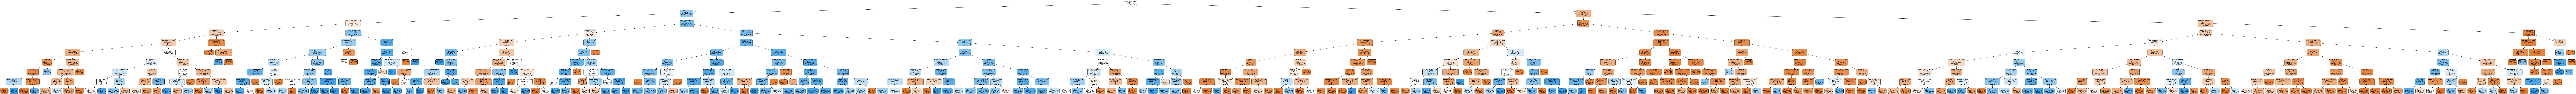

In [51]:
dot_data = StringIO()
export_graphviz(bestModelCW0, out_file=dot_data,filled=True, rounded=True,
                special_characters=True,feature_names = features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('CompanySuccess_dtmodelCW0.png')
Image(graph.create_png())

In [0]:
# dot_data = StringIO()
# export_graphviz(bestModelCW1, out_file=dot_data,filled=True, rounded=True,
#                 special_characters=True,feature_names = features,class_names=['0','1'])
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# graph.write_png('CompanySuccess_dtmodelCW1.png')
# Image(graph.create_png())

In [53]:
print('\nConfusion matrix for  class')
print(confusion_matrix(y_test, y_predCW0))

# print('\nConfusion matrix for balanced class')
# print(confusion_matrix(y_test, y_predCW1))



Confusion matrix for unbalanced class
[[5012 1571]
 [1349 5003]]


In [54]:
print('Classification Report for  class')
reportCW0 = classification_report(y_test,y_predCW0)
print(reportCW0)

# print('Classification Report for balanced class')
# reportCW1 = classification_report(y_test,y_predCW1)
# print(reportCW1)

Classification Report for unbalanced class
              precision    recall  f1-score   support

           0       0.79      0.76      0.77      6583
           1       0.76      0.79      0.77      6352

    accuracy                           0.77     12935
   macro avg       0.77      0.77      0.77     12935
weighted avg       0.77      0.77      0.77     12935



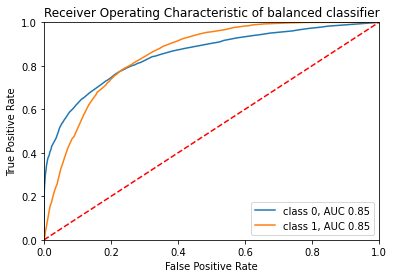

In [55]:
probs = bestModelCW0.predict_proba(X_test)
for i in range(0,2):
    preds = probs[:,i]
    fpr, tpr, threshold = roc_curve(y_test, preds, pos_label=i)
    roc_auc =auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'class {}, AUC {}'.format(i,roc_auc.round(2)))

plt.title('Receiver Operating Characteristic of balanced classifier')    
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [56]:
impFeatures = bestModelCW0.feature_importances_
impFeatures

array([1.90901938e-02, 1.69206186e-01, 8.36509729e-03, 1.19950640e-01,
       4.78535264e-02, 5.46732215e-01, 8.34850643e-03, 8.36242839e-04,
       2.10815380e-03, 3.26549604e-02, 2.11520058e-03, 0.00000000e+00,
       2.51338545e-03, 4.60252183e-04, 0.00000000e+00, 1.64904600e-02,
       3.74943583e-03, 1.48706837e-02, 3.45005309e-03, 2.96874627e-04,
       5.54938043e-04, 3.52994326e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text major ticklabel objects>)

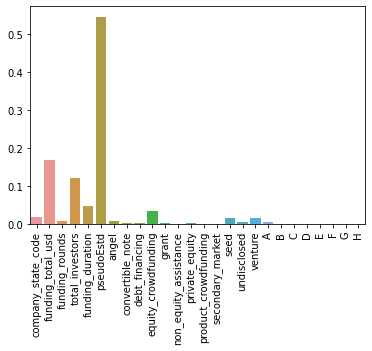

In [57]:
sns.barplot(x=features, y=impFeatures)
plt.xticks(rotation=90)

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [79]:
params = {
    'max_depth':[6,7,8,9],
    'max_features':[0.9, 1.0],
    'n_estimators':[20, 50, 75, 100]
}

rfClassifier = RandomForestClassifier(n_jobs=-1)
gridSearch = GridSearchCV(rfClassifier, params,verbose=1,n_jobs=-1,cv=5)
gridSearch.fit(X_train, y_train)
print(gridSearch.best_estimator_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  8.4min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features=0.9,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [80]:
bestClassifier = gridSearch.best_estimator_

rfTrainPredict = bestClassifier.predict(X_train)
rfTestPredict = bestClassifier.predict(X_test)
trainScore = accuracy_score(y_train, rfTrainPredict)
print("the accuracy score for training set : {}".format(trainScore))
testScore = accuracy_score(y_test, rfTestPredict)
print("the accuracy score for testing set : {}".format(testScore))

the accuracy score for training set : 0.8174420627403985
the accuracy score for testing set : 0.8063393892539621


In [85]:
print('\nConfusion matrix for  rf classifier')
print(confusion_matrix(y_test, rfTestPredict))


Confusion matrix for  rf classifier
[[5005 1578]
 [ 927 5425]]


In [86]:
print('Classification Report for rf class')
rfReport = classification_report(y_test,rfTestPredict)
print(rfReport)

Classification Report for rf class
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      6583
           1       0.77      0.85      0.81      6352

    accuracy                           0.81     12935
   macro avg       0.81      0.81      0.81     12935
weighted avg       0.81      0.81      0.81     12935



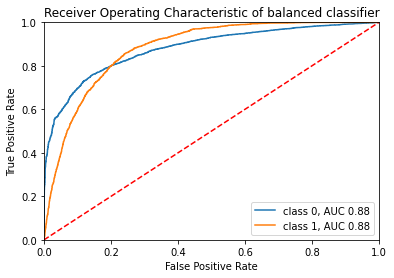

In [87]:
probs = bestClassifier.predict_proba(X_test)
for i in range(0,2):
    preds = probs[:,i]
    fpr, tpr, threshold = roc_curve(y_test, preds, pos_label=i)
    roc_auc =auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'class {}, AUC {}'.format(i,roc_auc.round(2)))

plt.title('Receiver Operating Characteristic of balanced classifier')    
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [82]:
impFeatures = bestClassifier.feature_importances_
impFeatures

array([2.32823142e-02, 1.95258125e-01, 8.32566441e-03, 1.12098189e-01,
       6.11484873e-02, 5.16158405e-01, 4.92466262e-03, 1.41362845e-03,
       5.33785389e-03, 2.00299002e-02, 3.11156078e-03, 1.78004564e-04,
       3.92593282e-03, 3.03408456e-04, 2.53072140e-04, 1.50588841e-02,
       2.72002572e-03, 1.55038716e-02, 4.65790625e-03, 2.92052828e-03,
       1.71398399e-03, 6.49496794e-04, 3.09138808e-04, 5.51334097e-04,
       1.51236824e-04, 1.43854077e-05])

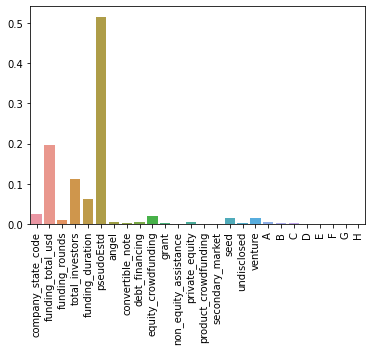

In [84]:
sns.barplot(x=features, y=impFeatures)
plt.xticks(rotation=90)
plt.show()

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K




In [0]:
def funcBaseModel(shape):

  inputLayer = Input(shape=(shape,))
  hiddenLayer1 = Dense(32, activation='relu')(inputLayer)
  hiddenLayer2 = Dense(32, activation='relu')(hiddenLayer1)
  hiddenLayer3 = Dense(16, activation='relu')(hiddenLayer2)
  outputLayer = Dense(1, activation='sigmoid')(hiddenLayer3)
  sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
  funcModel = Model(inputs = inputLayer, outputs = outputLayer)
  funcModel.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits =False), optimizer='adam', metrics=['accuracy'])
  return funcModel

In [155]:
model = funcBaseModel(26)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 26)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                864       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 2,465
Trainable params: 2,465
Non-trainable params: 0
_________________________________________________________________


In [134]:
from sklearn.preprocessing import MinMaxScaler
#normalization of continuous data
scaler = MinMaxScaler()
normalizedXTrain = scaler.fit_transform(X_train)
normalizedXTest = scaler.transform(X_test)
print(normalizedXTrain)

[[0.94339623 0.60713528 0.05555556 ... 0.         0.         0.        ]
 [0.09433962 0.75525954 0.11111111 ... 0.         0.         0.        ]
 [0.88679245 0.54219264 0.05555556 ... 0.         0.         0.        ]
 ...
 [0.67924528 0.69828173 0.         ... 0.         0.         0.        ]
 [0.75471698 0.75156116 0.         ... 0.         0.         0.        ]
 [0.41509434 0.69828173 0.         ... 0.         0.         0.        ]]


In [156]:
model.fit(normalizedXTrain, y_train, batch_size=16, epochs=40, validation_data=(normalizedXTest, y_test))

Epoch 1/40
3234/3234 [==============================] - 9s 3ms/step - loss: 0.5582 - accuracy: 0.7133 - val_loss: 0.5408 - val_accuracy: 0.7272
Epoch 2/40
3234/3234 [==============================] - 9s 3ms/step - loss: 0.5311 - accuracy: 0.7342 - val_loss: 0.5268 - val_accuracy: 0.7413
Epoch 3/40
3234/3234 [==============================] - 9s 3ms/step - loss: 0.5181 - accuracy: 0.7461 - val_loss: 0.5106 - val_accuracy: 0.7511
Epoch 4/40
3234/3234 [==============================] - 9s 3ms/step - loss: 0.5073 - accuracy: 0.7542 - val_loss: 0.5204 - val_accuracy: 0.7453
Epoch 5/40
3234/3234 [==============================] - 9s 3ms/step - loss: 0.4975 - accuracy: 0.7628 - val_loss: 0.4965 - val_accuracy: 0.7630
Epoch 6/40
3234/3234 [==============================] - 9s 3ms/step - loss: 0.4923 - accuracy: 0.7663 - val_loss: 0.4863 - val_accuracy: 0.7716
Epoch 7/40
3234/3234 [==============================] - 9s 3ms/step - loss: 0.4880 - accuracy: 0.7680 - val_loss: 0.4881 - val_accuracy:

In [157]:
modelPrediction = (model.predict(normalizedXTest)>0.5).astype('int')
score = accuracy_score(y_test, modelPrediction)
print(score)

0.788094317742559


In [158]:
print(confusion_matrix(y_test, modelPrediction))

[[4905 1678]
 [1063 5289]]


In [159]:
print(classification_report(y_test, modelPrediction))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      6583
           1       0.76      0.83      0.79      6352

    accuracy                           0.79     12935
   macro avg       0.79      0.79      0.79     12935
weighted avg       0.79      0.79      0.79     12935



In [0]:
def resNetSkips(numOfSkip, inputBlock, nodes=128, dropOut=0.5):
  if numOfSkip == 1:
    resNet = Dense(nodes)(inputBlock)
    resNet = BatchNormalization()(resNet)
    resNet = Activation('relu')(resNet)
    outputBlock = tf.keras.layers.add([resNet, inputBlock])
    return outputBlock

  if numOfSkip == 2:
    resNet = Dense(nodes)(inputBlock)
    resNet = BatchNormalization()(resNet)
    resNet = Activation('relu')(resNet)
    resNet = Dropout(dropOut)(resNet)
    resNet = Dense(nodes)(resNet)
    resNet = BatchNormalization()(resNet)
    outputBlock = tf.keras.layers.add([resNet, inputBlock])
    return outputBlock
  
  if numOfSkip == 3:
    resNet = Dense(nodes)(inputBlock)
    resNet = BatchNormalization()(resNet)
    resNet = Activation('relu')(resNet)
    resNet = Dropout(dropOut)(resNet)
    resNet = Dense(nodes)(resNet)
    resNet = BatchNormalization()(resNet)
    resNet = Activation('relu')(resNet)
    resNet = Dropout(dropOut)(resNet)
    resNet = Dense(nodes)(resNet)
    resNet = BatchNormalization()(resNet)
    outputBlock = tf.keras.layers.add([resNet, inputBlock])
    return outputBlock

def getResNetModel(inputShape, residualBlockDepths, skipConnection, numNodes=128, learningRate=0.001, dropOut=0.5):
  inputs = Input(shape=(inputShape,), name='img')
  resNetwork = Dense(numNodes, activation='relu')(inputs)
  blockOutput = Dense(numNodes, activation='relu')(resNetwork)

  for i in range(residualBlockDepths):
    blockOutput = resNetSkips(skipConnection, blockOutput, numNodes, dropOut)

  
  resNetwork = Dense(numNodes, activation='relu')(blockOutput)
  resNetwork = Dropout(dropOut)(resNetwork)
  outputs = Dense(1, activation='sigmoid')(resNetwork)

  resNetworkModel = tf.keras.Model(inputs = inputs, outputs = outputs, name='resnetwork')
  resNetworkModel.compile(optimizer='adam', loss = tf.keras.losses.BinaryCrossentropy(from_logits =False), metrics=['accuracy'])
  return resNetworkModel
  

In [180]:
resNetModel = getResNetModel(26, 4, 2, 32, 0.2)
resNetModel.summary()

Model: "resnetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 26)]         0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 32)           864         img[0][0]                        
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 32)           1056        dense_16[0][0]                   
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 32)           1056        dense_17[0][0]                   
_________________________________________________________________________________________

In [181]:
resNetModel.fit(normalizedXTrain, y_train, batch_size=16, epochs=40, validation_data=(normalizedXTest, y_test))

Epoch 1/40
3234/3234 [==============================] - 25s 8ms/step - loss: 0.6344 - accuracy: 0.6719 - val_loss: 0.5460 - val_accuracy: 0.7377
Epoch 2/40
3234/3234 [==============================] - 25s 8ms/step - loss: 0.5568 - accuracy: 0.7327 - val_loss: 0.7294 - val_accuracy: 0.6281
Epoch 3/40
3234/3234 [==============================] - 25s 8ms/step - loss: 0.5394 - accuracy: 0.7417 - val_loss: 0.5319 - val_accuracy: 0.7382
Epoch 4/40
3234/3234 [==============================] - 25s 8ms/step - loss: 0.5316 - accuracy: 0.7495 - val_loss: 0.5229 - val_accuracy: 0.7507
Epoch 5/40
3234/3234 [==============================] - 25s 8ms/step - loss: 0.5283 - accuracy: 0.7522 - val_loss: 0.6098 - val_accuracy: 0.7122
Epoch 6/40
3234/3234 [==============================] - 26s 8ms/step - loss: 0.5267 - accuracy: 0.7542 - val_loss: 0.5047 - val_accuracy: 0.7581
Epoch 7/40
3234/3234 [==============================] - 26s 8ms/step - loss: 0.5198 - accuracy: 0.7585 - val_loss: 0.5666 - val_ac

In [182]:
resnetPredict = (resNetModel.predict(normalizedXTest)>0.5).astype('int')
score = accuracy_score(y_test, resnetPredict)
print(score)

0.7820641669887901


In [183]:
print(confusion_matrix(y_test, resnetPredict))

[[4816 1767]
 [1052 5300]]


In [184]:
print(classification_report(y_test, resnetPredict))

              precision    recall  f1-score   support

           0       0.82      0.73      0.77      6583
           1       0.75      0.83      0.79      6352

    accuracy                           0.78     12935
   macro avg       0.79      0.78      0.78     12935
weighted avg       0.79      0.78      0.78     12935

